In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install xgboost

##Load the preprocessed Dataset

In [ ]:
import numpy as np       
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import pickle
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split

path = "/content/drive/MyDrive/Bachelorarbeit/preprocessed2013_porto_taxi.csv"
df = pd.read_csv(path)

In [ ]:
df.describe()

Identify which features are of object type, change them to float or integer and finally add few features to train our model.

In [ ]:
df.info()

In [ ]:
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')
df["pickup_weekday"] = df["pickup_datetime"].dt.weekday
df["dropoff_weekday"] = df["dropoff_datetime"].dt.weekday
# Get latitude and longitude differences
df["latitude_difference"] = df["dropoff_latitude"] - df["pickup_latitude"]
df["longitude_difference"] = df["dropoff_longitude"] - df["pickup_longitude"]

## Train and Save the XGBoost Model
#### The following features were used to train the model and predict trip duration in minutes: *'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance', 'pickup_weekday', 'pickup_hour', 'pickup_minute'.*

In [ ]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.api import abline_plot
import seaborn as sns


def rmsle(y_true, y_pred):
    labels = y_pred.get_label()
    diffs = np.log(y_true + 1) - np.log(labels + 1)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('RMSLE', np.sqrt(avg))

def XGBmodel(X, y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
  dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
  dtest = xgb.DMatrix(X_test, np.log(y_test+1))

  params = {
    'min_child_weight': 1, 
    'learning_rate': 0.1, 
    'colsample_bytree': 0.7, 
    'max_depth': 14,
    'subsample': 0.9,
    'n_estimators': 500,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'feval': 'rmsle',
    }
  watchlist = [(dtest, 'eval'), (dtrain, 'train')]
  # Number of training rounds
  nrounds = 500
  # Train model
  gbm = xgb.train(params, dtrain, num_boost_round = nrounds, evals = watchlist, feval=rmsle,  verbose_eval = True)

  # Test predictions
  y_pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1
  # Mean absolute error to get a basic estimate of the error
  mae = (abs(y_pred - y_test)).mean()
  print('Mean Absolute Error:', mae)
  print(max(y_pred))

  # plotting residuals
  residuals = y_test - y_pred
  max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
  print("Max Error:", "{:,.0f}".format(max_error))
  

    #Frequency Distributions of Residuals
  plt.figure(figsize=(10,7))
  plt.hist(residuals, bins=60, edgecolor='black')
  plt.xlabel('Residuals', fontsize = 18)
  plt.ylabel('Count', fontsize = 18)
  plt.title('Frequency Distributions of Residuals in Porto Taxi Dataset', fontsize = 18)
  plt.tick_params(axis='both', which='major', labelsize=18)
  plt.show()


  return gbm

X = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance','pickup_month', 'pickup_weekday', 'pickup_hour', 'pickup_minute']]
y = df['trip_time']
model = XGBmodel(X, y)
filename = "porto_xgboost_model.sav"
pickle.dump(model, open(filename, 'wb'))
X.describe()


## Load the saved model

In [ ]:
filename = "porto_xgboost_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

## Install the scikit-opt Library for the Algorithms

In [ ]:
!pip install sko
!pip install scikit-opt

##Objective Function
##### The following code was borrowed from these repositories and modified to apply Genetic Algorithms to the problem. 
1. https://github.com/khanhnamle1994/trip-optimizer/blob/master/Bio-Inspired-Algorithms/genetic_evo_main.py#L1
2. https://github.com/guofei9987/scikit-opt/blob/master/examples/demo_ga_udf_tsp.py

In [ ]:
 from sko.GA import GA_TSP
from scipy import spatial
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pprint

geolocator = Nominatim(user_agent="aco-application")

filename = "porto_xgboost_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

def time_cost_between_points(loc1, loc2, pickup_weekday, pickup_month, pickup_hour, pickup_minute):
    """
    Calculate the time (in minutes) between two points
    using the trained XGB model
    """

    model_data = {'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'trip_distance': trip_distance_cost(loc1, loc2),
                  'pickup_month': pickup_month,
                  'pickup_weekday': pickup_weekday,
                  'pickup_hour': pickup_hour,
                  'pickup_minute': pickup_minute,
                  }

    print(model_data)
    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    #print(pred[0])
    return pred[0]


def trip_distance_cost(loc1, loc2):
    """
    Calculate the manhattan distance between two points using
    polar coordinates in taxicab geometry https://en.wikipedia.org/wiki/Taxicab_geometry
    """
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))


def total_cost_from_path(path):
    """
    Calculate the time (in minutes) to travel a path
    using the trained XGB model
    """
    total_cost = 0
    for i in range(1, len(path)):
        j = i - 1
        total_cost += cost_matrix[path[j]][path[i]]
    # Find time it takes to go back to original location
    total_cost += cost_matrix[path[-1]][path[0]]
    return total_cost
    #print('total cost', total_cost)



locations = []
points = []

for index, row in df.iloc[:99].iterrows(): #take the first 100 rows within the dataset as input coordinates

        locations.append({
              'index': index,
              'x': row['pickup_longitude'],
              'y': row['pickup_latitude']
          })
        points.append((row['pickup_longitude'], row['pickup_latitude']))

# Build complete cost matrix based on time between points
cost_matrix = []
rank = len(locations)
for i in range(rank):
    row = []
    for j in range(rank):
        row.append(time_cost_between_points(locations[i], locations[j], 1, 8, 18, 34))
    cost_matrix.append(row)
print(cost_matrix)


# 1. Genetic Algorithms

Execution time: 68.81582117080688 seconds 
Final cost: [418.51386929] minutes, path: [46 98 70 75 47 43 28 93 32 49 10 94 76 35 84 15 52 92 90 51 38 74 81  2
 41  0 20 22 87  5 26  6  7 21 78 11 25 80 86 44  9 58 29 54 12 27 53 97
 88 14  8 39 77 19 63 16  1 69 55 96 42 89 13 79 17 33 18 66 82 56 40 85
 61 50 62 60 37 83 31 30  3 67 95  4 71 73 45 65 23 72 48 57 36 59 24 34
 68 64 91], for 2000 generations
Min cost mean: 429.55091444571775
Min cost standard deviation: 22.68619280907566


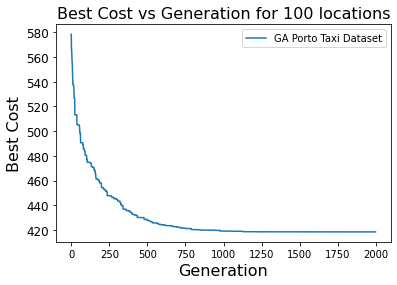

'\nax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], \'o-r\')\nax[0].set_xlabel(\'Longitude\')\nax[0].set_xlabel(\'Latuitude\')\nax[0].set_title(\'Trip Coordinates\')\n\nax[1].plot(ga_tsp.generation_best_Y)\nax[1].set_xlabel(\'Generation\')\nax[1].set_xlabel(\'Best Cost\')\nax[1].set_title("Best Cost vs Generation for " + str(ga_tsp.max_iter+1) + " Population")\nplt.show()\n'

In [ ]:
import time

num_points = 99
population = 120
generations =1999
mutation_factor = 1

start_time = time.time()
ga_tsp = GA_TSP(func=total_cost_from_path, n_dim=num_points, size_pop=population, max_iter=generations, prob_mut=mutation_factor)
best_path, best_time_cost = ga_tsp.run()
print("Execution time: %s seconds " % (time.time() - start_time))
print('Final cost: {} minutes, path: {}, for {} generations' .format(best_time_cost, best_path, str(ga_tsp.max_iter+1)))
print("Min cost mean:", np.mean(ga_tsp.generation_best_Y))
print("Min cost standard deviation:", np.std(ga_tsp.generation_best_Y))
#print('Chromosome new', ga_tsp.Chrom )
#print('Chromosome old', swap(ga_tsp.Chrom) )

points_arr = np.array(points)
#fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_path, [best_path[0]]])
best_points_coordinate = points_arr[best_points_, :]
# plot lines
#plt.plot(ga_tsp.generation_best_Y, label = "GA Porto")
#plt.plot(aca.generation_best_Y, label = "ACA")
# plt.plot(sa_tsp.generation_best_Y, label = "SA")
plt.xlabel('Generation', fontsize=16)
plt.ylabel('Best Cost', fontsize=16)
plt.yticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(ga_tsp.generation_best_Y, label = "GA Porto Taxi Dataset")
plt.title("Best Cost vs Generation for 100 locations", fontsize=16)
plt.legend()
plt.show()
'''
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[0].set_xlabel('Longitude')
ax[0].set_xlabel('Latuitude')
ax[0].set_title('Trip Coordinates')

ax[1].plot(ga_tsp.generation_best_Y)
ax[1].set_xlabel('Generation')
ax[1].set_xlabel('Best Cost')
ax[1].set_title("Best Cost vs Generation for " + str(ga_tsp.max_iter+1) + " Population")
plt.show()
'''
#print('total cost', cost_matrix[0,0])

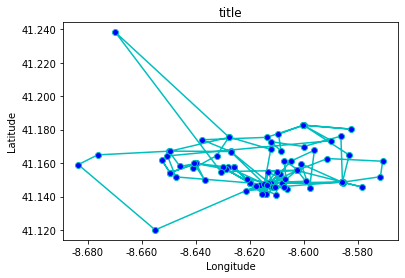

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-12-bab2d1fb5c5a>", line 24, in update_scatter
    point_coordinate = best_points_coordinate[points, :]
IndexError: arrays used as indices must be of integer (or boolean) type


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter


best_x_history = ga_tsp.all_history_Y

fig2, ax2 = plt.subplots(1, 1)
ax2.set_title('title', loc='center')
line = ax2.plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1],
                marker='o', markerfacecolor='b', color='c', linestyle='-')
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
plt.ion()
p = plt.show()


def update_scatter(frame):
    ax2.set_title('iter = ' + str(frame))
    points = best_x_history[frame]
    points = np.concatenate([points, [points[0]]])
    point_coordinate = best_points_coordinate[points, :]
    plt.setp(line, 'xdata', point_coordinate[:, 0], 'ydata', point_coordinate[:, 1])
    return line


ani = FuncAnimation(fig2, update_scatter, blit=True, interval=100, frames=len(best_x_history))
plt.show()
#ani.save('ga1.gif', writer='pillow')

# 2. Ant Colony Optimization (scikit-opt)

Execution time: 354.082914352417 seconds 
Final cost: 396.337096452713 minutes, path: [ 0 79 52  3 15 87 30 20 22 84  5 92 38 21 90 46 76 94 12 27 53 88 80 91
 16 33 25 19 55 39 77 58  9 37 71 73 29 23 62 40 98 74 56  6  7 35 10 13
 85 78 17 67 42 65 11 48 82 70 57 61 36  2 50 96 81 41  8 59 24 69 63 72
  1 89 51 18 66 45 97 86 44 14  4 47 68 43 32 49 75 26 83 28 93 31 34 95
 54 60 64], for 800 generations
Min cost mean: 406.86645187693034
Min cost standard deviation: 9.100968141520433


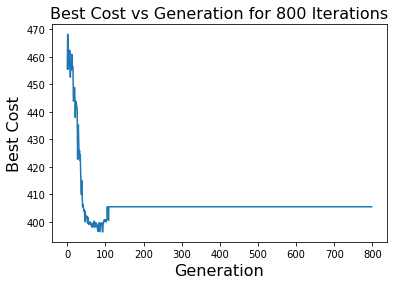

'\nax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], \'o-r\')\nax[0].set_xlabel(\'Longitude\')\nax[0].set_xlabel(\'Latuitude\')\nax[0].set_title(\'Trip Coordinates\')\nax[1].plot(aca.generation_best_Y)\nax[1].set_xlabel(\'Generation\')\nax[1].set_xlabel(\'Best Cost\')\nax[1].set_title("Best Cost vs Generation for " + str(aca.max_iter+1) + " Population")\nplt.show()\n'

In [ ]:
from sko.ACA import ACA_TSP
import time

num_points = 99
population = 50
generations = 799

start_time = time.time()
aca = ACA_TSP(func=total_cost_from_path, n_dim=num_points,
              size_pop=population, max_iter=generations,
              distance_matrix=cost_matrix, alpha=2, beta=5)

best_path, best_time_cost = aca.run()
print("Execution time: %s seconds " % (time.time() - start_time))


print('Final cost: {} minutes, path: {}, for {} generations' .format(best_time_cost, best_path, str(aca.max_iter+1)))
print("Min cost mean:", np.mean(aca.generation_best_Y))
print("Min cost standard deviation:", np.std(aca.generation_best_Y))

points_arr = np.array(points)
#fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_path, [best_path[0]]])
best_points_coordinate = points_arr[best_points_, :]

plt.plot(aca.generation_best_Y, label = "ACO Porto")
plt.xlabel('Generation', fontsize=16)
plt.ylabel('Best Cost', fontsize=16)
plt.title("Best Cost vs Generation for " + str(aca.max_iter+1) + " Iterations", fontsize=16)
#plt.plot(ga_tsp.generation_best_Y, label = "ACO")
plt.show()
'''
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[0].set_xlabel('Longitude')
ax[0].set_xlabel('Latuitude')
ax[0].set_title('Trip Coordinates')
ax[1].plot(aca.generation_best_Y)
ax[1].set_xlabel('Generation')
ax[1].set_xlabel('Best Cost')
ax[1].set_title("Best Cost vs Generation for " + str(aca.max_iter+1) + " Population")
plt.show()
'''

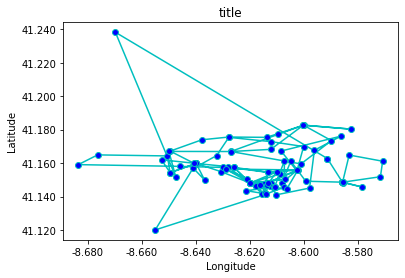

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter


best_x_history = aca.x_best_history

fig2, ax2 = plt.subplots(1, 1)
ax2.set_title('title', loc='center')
line = ax2.plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1],
                marker='o', markerfacecolor='b', color='c', linestyle='-')
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
plt.ion()
p = plt.show()


def update_scatter(frame):
    ax2.set_title('iter = ' + str(frame))
    points = best_x_history[frame]
    points = np.concatenate([points, [points[0]]])
    point_coordinate = best_points_coordinate[points, :]
    plt.setp(line, 'xdata', point_coordinate[:, 0], 'ydata', point_coordinate[:, 1])
    return line


ani = FuncAnimation(fig2, update_scatter, blit=True, interval=100, frames=len(best_x_history))
plt.show()
ani.save('aco.gif', writer='pillow')

# 3. Simulated Annealing (scikit-opt)

Execution time: 250.8211522102356 seconds 
Final cost: 390.19649028778076 minutes, path: [98 61 11 19 55 59 24 89 51 79 52 84  5  3 87 15  0 34 43 12 27 53 23 72
  1 69 13 18 46 74 66 40 21 50 25 14 86 37 58 83 28 93 32 31 49 75 54 60
 88 97  4  9 44 71 73 29 45 57 36  2 90 10 26 38  7 35 20 22 92 30 76 94
 68 64 95 47 80 91 39 77 85 82 70 96 56  6 17 67 42 65 78 63 62 48 81 41
  8 16 33], for 1981 iterations
Min cost mean: 392.0000030888103
Min cost standard deviation: 7.4708623913394705


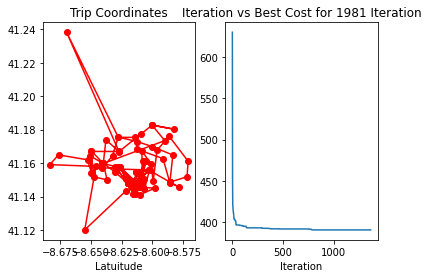

In [ ]:
from sko.SA import SA_TSP
from scipy import spatial
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from matplotlib.ticker import FormatStrFormatter
import pprint

geolocator = Nominatim(user_agent="aco-application")

loaded_model = pickle.load(open(filename, 'rb'))

num_points = 99

start_time = time.time()

sa_tsp = SA_TSP(func=total_cost_from_path, T_max=1, T_min=1e-4, max_stay_counter=400, L=20 * num_points, x0=range(num_points))

best_path, best_time_cost = sa_tsp.run()
print("Execution time: %s seconds " % (time.time() - start_time))


print('Final cost: {} minutes, path: {}, for {} iterations' .format(best_time_cost, best_path, str(sa_tsp.L+1)))
print("Min cost mean:", np.mean(sa_tsp.generation_best_Y))
print("Min cost standard deviation:", np.std(sa_tsp.generation_best_Y))

points_arr = np.array(points)
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_path, [best_path[0]]])
best_points_coordinate = points_arr[best_points_, :]

ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[0].set_xlabel('Longitude')
ax[0].set_xlabel('Latuitude')
ax[0].set_title('Trip Coordinates')

ax[1].plot(sa_tsp.generation_best_Y)
ax[1].set_xlabel('Best Cost')
ax[1].set_xlabel('Iteration')
ax[1].set_title("Iteration vs Best Cost for " + str(sa_tsp.L+1) + " Iteration")
plt.show()

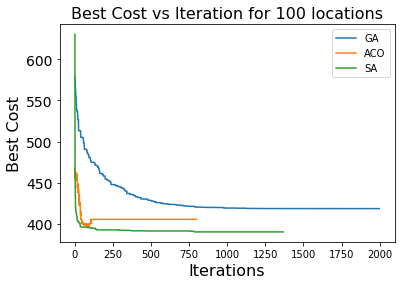

In [ ]:
# plot lines
plt.plot(ga_tsp.generation_best_Y, label = "GA")
plt.plot(aca.generation_best_Y, label = "ACO")
plt.plot(sa_tsp.generation_best_Y, label = "SA")
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Best Cost', fontsize=16)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.plot(ga_tsp.generation_best_Y, label = "GA Porto Taxi Dataset")
plt.title("Best Cost vs Iteration for 100 locations", fontsize=16)
plt.legend()
plt.show()

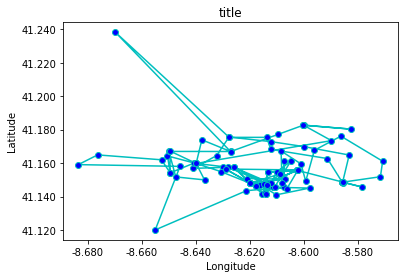

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

best_x_history = sa_tsp.best_x_history

fig2, ax2 = plt.subplots(1, 1)
ax2.set_title('title', loc='center')
line = ax2.plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1],
                marker='o', markerfacecolor='b', color='c', linestyle='-')
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
plt.ion()
p = plt.show()


def update_scatter(frame):
    ax2.set_title('iter = ' + str(frame))
    points = best_x_history[frame]
    points = np.concatenate([points, [points[0]]])
    point_coordinate = best_points_coordinate[points, :]
    plt.setp(line, 'xdata', point_coordinate[:, 0], 'ydata', point_coordinate[:, 1])
    return line


ani = FuncAnimation(fig2, update_scatter, blit=True, interval=100, frames=len(best_x_history))
plt.show()
ani.save('sa_tsp2.gif', writer='pillow')
